# Notebook de départ

Ce notebook est un point de départ qui vous montre la base de comment accéder aux données et en extraire la distribution de la pseudo-rapidité $\eta$ des traces.

## Importation de modules python

La plupart des notebooks jupyter commencent par une liste d'importation de modules python qui sont ensuite utilisés.
Dans ce projet les modules de base sont : 
- [uproot](https://uproot.readthedocs.io/en/latest/) pour lire (et écrire) des données au format [ROOT](https://root.cern.ch) (mais sans avoir besoin d'installer ROOT)
- [awkward](https://awkward-array.readthedocs.io/en/latest/) pour manipuler des tableaux avec des structures de taille variable (qui sont ce que l'on utilise couramment en physique des hautes énergies, e.g. chaque événement contient potentiellement un nombre différent de muons)
- [numpy](https://numpy.org) qui est la base de la base des modules de "scientific computing" dans le monde Python. Un peu moins nécessaire dans notre cas (les awkward arrays sont généralement plus adaptés) mais certainement un module à connaître et à explorer dans votre future carrière.
- [matplotlib](https://matplotlib.org) pour créer de nombreux types de visualisations
- [hist](https://hist.readthedocs.io/en/latest/index.html) pour créer des histogrammes
- [vector](https://vector.readthedocs.io/en/latest/index.html) pour manipuler des vecteurs 2D, 3D et Lorentz.

Pour apprendre et pratiquer ces modules, voir par exemple un [tutorial récent](https://github.com/jpivarski-talks/2021-09-13-star-uproot-awkward-tutorial/blob/main/tutorial.ipynb)


In [1]:
import uproot
import awkward as ak
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import hist
import vector
print("uproot version",uproot.__version__)
print("awkward version",ak.__version__)
print("numpy version",np.__version__)
print("matplotlib version",matplotlib.__version__)
print("hist version",hist.__version__)
print("vector version",vector.__version__)

uproot version 5.0.12
awkward version 2.4.3
numpy version 1.25.2
matplotlib version 3.8.0
hist version 2.7.2
vector version 1.1.1


## Emplacement des données

Les données à analyser/explorer/visualiser sont dans le répertoire `/pbs/throng/training/nantes-m2-rps-exp/data`. Pour chaque run, il y a deux fichiers, l'un correspondant aux vraies données,  `runXXX.data.root`, l'autre à des données simulées (dans les mêmes conditions que les données réelles), `runXXX.mc.root`.

In [2]:
!ls -alh /pbs/throng/training/nantes-m2-rps-exp/data/*291263*

-rwxrwxr-x 1 2830 training 414M Aug 30 17:32 /pbs/throng/training/nantes-m2-rps-exp/data/run291263.data.root
-rwxrwxr-x 1 2830 training  26M Aug 30 17:57 /pbs/throng/training/nantes-m2-rps-exp/data/run291263.mc.root


## Exploration rapide des données (i.e. le format des données)

In [3]:
file = uproot.open("/pbs/throng/training/nantes-m2-rps-exp/data/run291263.data.root")

In [4]:
file.keys()

['eventsTree;1']

In [5]:
events = file["eventsTree"]
events.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
runNumber            | int32_t                  | AsDtype('>i4')
xVtx                 | double                   | AsDtype('>f8')
yVtx                 | double                   | AsDtype('>f8')
zVtx                 | double                   | AsDtype('>f8')
isCINT               | bool                     | AsDtype('bool')
isCMSL               | bool                     | AsDtype('bool')
isCMSH               | bool                     | AsDtype('bool')
isCMLL               | bool                     | AsDtype('bool')
isCMUL               | bool                     | AsDtype('bool')
nMuons               | int32_t                  | AsDtype('>i4')
Muon_E               | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
Muon_Px              | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
Muon_Py              

L'idée est ensuite de mettre les variables d'intérêt dans des tableaux que l'on manipulera ensuite. Par exemple on récupère ci-dessous des tableaux contenant le nombre de traces par événement, les composantes x,y,z de l'impulsion des traces et leur charge; et ceci pour les 10000 premiers événements (pour que le reste de ce notebook d'exemple ne soit pas trop lent). 

In [6]:
m = events.arrays(["nMuons","Muon_Px","Muon_Py","Muon_Pz","Muon_Charge"],how="zip",entry_stop=10000)
type(m)

awkward.highlevel.Array

Ce tableau peut être indexé de différentes façons. Avec un index unique pour accéder un seul élément : 

In [7]:
m[401].to_list()

{'nMuons': 5,
 'Muon': [{'Px': -1.1181609630584717,
   'Py': 0.18271270394325256,
   'Pz': -4.980171203613281,
   'Charge': -1},
  {'Px': -1.2175788879394531,
   'Py': 0.7182918787002563,
   'Pz': -6.48806095123291,
   'Charge': -1},
  {'Px': -1.2664967775344849,
   'Py': 0.7802225947380066,
   'Pz': -6.75444221496582,
   'Charge': -1},
  {'Px': 0.10596668720245361,
   'Py': 0.21960943937301636,
   'Pz': -3.213592052459717,
   'Charge': -1},
  {'Px': -0.031601566821336746,
   'Py': 0.2911522090435028,
   'Pz': -3.198549509048462,
   'Charge': -1}]}

> Challenge : l'index 401 correspond en fait au premier événement qui a 5 muons dans cet échantillon de données. Comment trouver cet index rapidement ? Combien y a-t'il d'événements avec 5 muons dans cet échantillon ? 

Un index négatif est relatif à la fin du tableau. Le dernier événement est : 

In [8]:
m[-1].to_list()

{'nMuons': 2,
 'Muon': [{'Px': 0.09250666201114655,
   'Py': -0.5921716690063477,
   'Pz': -8.13140869140625,
   'Charge': -1},
  {'Px': -0.4061260223388672,
   'Py': 0.627348005771637,
   'Pz': -7.963470458984375,
   'Charge': 1}]}

L'index peut également décrire un intervalle, e.g. pour afficher les 3 premiers événements :  

In [9]:
m[0:3].to_list()

[{'nMuons': 1,
  'Muon': [{'Px': 0.3627656400203705,
    'Py': 1.5258479118347168,
    'Pz': -23.331602096557617,
    'Charge': 1}]},
 {'nMuons': 1,
  'Muon': [{'Px': 0.6496245861053467,
    'Py': 0.5048883557319641,
    'Pz': -11.40880012512207,
    'Charge': -1}]},
 {'nMuons': 0, 'Muon': []}]

Un index peut également être un tableau de booléen où les valeurs à True indiquent les valeurs à indexer. Par exemple pour afficher le premier événement qui possède au moins 2 muons :

In [10]:
m[m.nMuons>1][0].to_list()

{'nMuons': 2,
 'Muon': [{'Px': 0.5758066177368164,
   'Py': 0.7083165645599365,
   'Pz': -9.437490463256836,
   'Charge': 1},
  {'Px': 0.5754270553588867,
   'Py': 0.6730052828788757,
   'Pz': -9.702540397644043,
   'Charge': -1}]}

## Calcul de la pseudo-rapidité 

Définissons maintenant quelques fonctions pour calculer la pseudo-rapidité $\eta$ d'un tri-vecteur... 

In [11]:
def mag(px:float,py:float,pz:float):
    """Returns the norm of the 3-vector (px,py,pz)."""
    return math.sqrt(px*px+py*py+pz*pz)

def costheta(px:float,py:float,pz:float):
    """Returns the cos(theta) of the 3 vector (px,py,pz)."""
    ptot = mag(px,py,pz);
    return 1.0 if ptot == 0.0 else pz/ptot

def eta(px:float,py:float,pz:float):
    """Returns the pseudo-rapidity of the 3 vector (px,py,pz)."""
    ct = costheta(px,py,pz)
    if ct*ct < 1:
        return -0.5* math.log((1.0-ct)/(1.0+ct))
    if pz==0: 
        return 0
    if pz>0: 
        return 10E10
    else:
        return -10E20


Puis on créé un tableau des valeurs de $\eta$ pour tous les muons (notez que l'on sélectionne les événements qui ont au moins un muon)

In [12]:
etas = np.array([],dtype=float)
nofTracks=0 # il est toujours utile de compter ...
nofEvents=0 # 
for event in m[m.nMuons>0]:
    nofEvents+=1
    tracks = event["Muon"].to_list()
    for t in tracks:
        nofTracks+=1
        etas = np.append(etas,eta(t["Px"],t["Py"],t["Pz"])) 

In [13]:
# ... et de vérifier que le compte est bon !
print(nofEvents,len(etas),nofTracks)

5922 6979 6979


## Visualisation de la pseudo-rapidité des muons

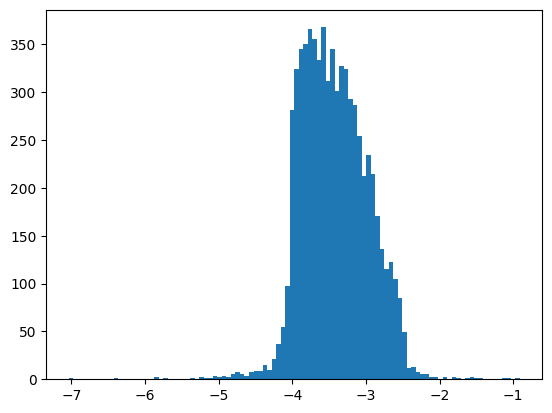

In [14]:
plt.hist(etas,bins=100);

La librarie [matplotlib](https://matplotlib.org) permet bien entendu de peaufiner cette figure autant que l'on souhaite... Par exemple en spécifiant un titre, en nommant les axes et en ajoutant une légende.

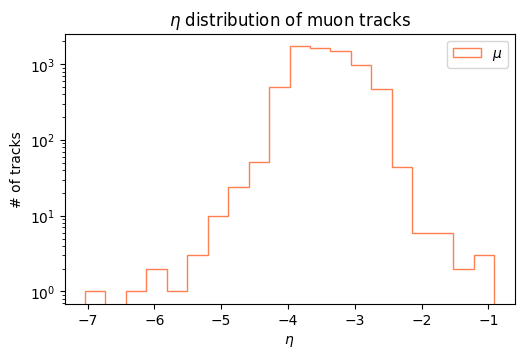

In [15]:
fig = plt.figure(figsize=(5,3))
axes = fig.add_axes([0.1,0.1,0.9,0.9])
axes.set_title("$\eta$ distribution of muon tracks")
axes.set_xlabel("$\eta$")
axes.set_ylabel("# of tracks")
axes.set_yscale("log")
axes.hist(etas,bins=20,label="$\mu$",color='coral',histtype='step');
axes.legend();


## Exercices conseillés

Afin de vous familiariser avec les outils, essayez maintenant de faire un plot de l'impulsion transverse des muons. 

In [16]:
def pT(px:float, py:float):
    return np.sqrt(px*px + py*py)

In [17]:
pTs = np.array([], dtype = float)
nofTracks=0 # il est toujours utile de compter ...
nofEvents=0 # 
for event in m[m.nMuons>0]:
    nofEvents+=1
    tracks = event["Muon"].to_list()
    for t in tracks:
        nofTracks+=1
        pTs = np.append(pTs, pT(t["Px"], t["Py"]))

In [18]:
# ... et de vérifier que le compte est bon !
print(nofEvents,len(pTs),nofTracks)

5922 6979 6979


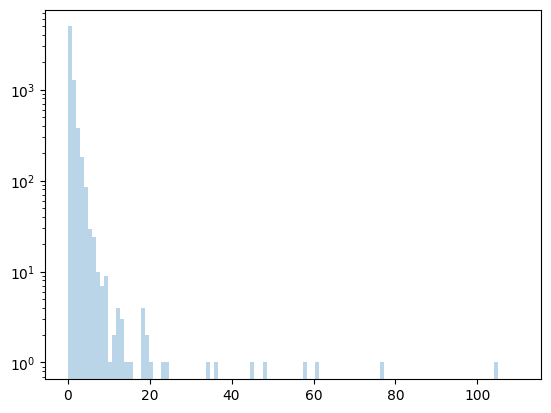

In [19]:
kwargs = dict(range = [0, 110], histtype = 'stepfilled', alpha = 0.3, bins = 111)
plt.hist(pTs, **kwargs)
plt.yscale("log")

Puis, sur un même plot, tracer séparemment les 𝜇+ et les 𝜇−.

In [20]:
pTs_plus = np.array([], dtype = float)
pTs_minus = np.array([], dtype = float)
nofTracks=0 # il est toujours utile de compter ...
nofEvents=0 # 
for event in m[m.nMuons>0]:
    nofEvents+=1
    tracks = event["Muon"].to_list()
    for t in tracks:
        nofTracks+=1
        if t["Charge"] == 1:
            pTs_plus = np.append(pTs_plus, pT(t["Px"], t["Py"]))
        if t["Charge"] == -1:
            pTs_minus = np.append(pTs_minus, pT(t["Px"], t["Py"]))

In [21]:
# ... et de vérifier que le compte est bon !
print(nofEvents, len(pTs_plus)+len(pTs_minus), nofTracks)

5922 6979 6979


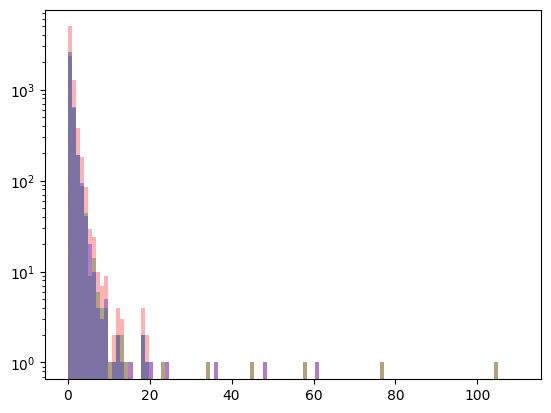

In [22]:
plt.hist(pTs, color = 'red', **kwargs)
plt.hist(pTs_minus, color = 'green', **kwargs)
plt.hist(pTs_plus, color = 'blue', **kwargs)
plt.yscale('log')

Enfin, observez la distribution du nombre de muons par événement et attaquez vous aux caractéristiques des paires de muons (masse invariante, impulsion transverse, rapidité, ...) !
Et, pour avoir une première idée de comment analyser efficacement un ensemble de données conséquent, jetez un oeil au [notebook suivant](./02-analyze-more-data.ipynb)

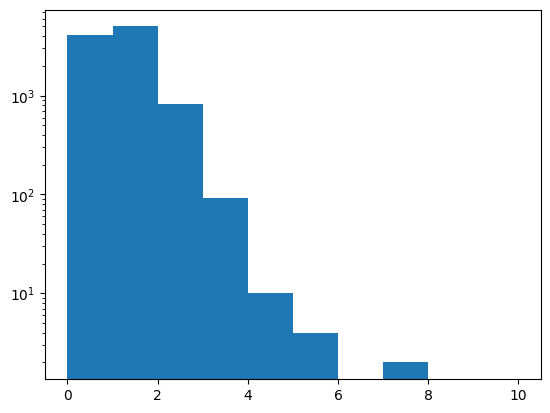

In [23]:
plt.hist(m.nMuons,bins=[0,1,2,3,4,5,6,7,8,9,10])
plt.yscale("log")

In [24]:
print("Nombre total d'événements: {}".format(len(m)))
n1 = len(m[m.nMuons>0])
n2 = len(m[m.nMuons>1])
n3 = len(m[m.nMuons>2])
n4 = len(m[m.nMuons>3])
n5 = len(m[m.nMuons>4])
n6 = len(m[m.nMuons>5])
n7 = len(m[m.nMuons>6])
n8 = len(m[m.nMuons>7])
print("Nombre d'événements avec au moins une trace: {}".format(n1))
print("Nombre d'événements avec au moins deux traces: {}".format(n2))
print("Nombre d'événements avec au moins trois traces: {}".format(n3))
print("Nombre d'événements avec au moins quatre traces: {}".format(n4))
print("Nombre d'événements avec au moins cinq traces: {}".format(n5))
print("Nombre d'événements avec au moins six traces: {}".format(n6))
print("Nombre d'événements avec au moins sept traces: {}".format(n7))
print("Nombre d'événements avec au moins huit traces: {}".format(n8))

Nombre total d'événements: 10000
Nombre d'événements avec au moins une trace: 5922
Nombre d'événements avec au moins deux traces: 922
Nombre d'événements avec au moins trois traces: 109
Nombre d'événements avec au moins quatre traces: 16
Nombre d'événements avec au moins cinq traces: 6
Nombre d'événements avec au moins six traces: 2
Nombre d'événements avec au moins sept traces: 2
Nombre d'événements avec au moins huit traces: 0


In [25]:
assert(n1+n2+n3+n4+n5+n6+n7+n8==nofTracks)

In [26]:
_ = events.arrays(["nMuons", "Muon_Px", "Muon_Py", "Muon_Pz", "Muon_E", "Muon_Charge"], how="zip", entry_stop=10000)

In [27]:
_[401].to_list()

{'nMuons': 5,
 'Muon': [{'Px': -1.1181609630584717,
   'Py': 0.18271270394325256,
   'Pz': -4.980171203613281,
   'E': 5.108515739440918,
   'Charge': -1},
  {'Px': -1.2175788879394531,
   'Py': 0.7182918787002563,
   'Pz': -6.48806095123291,
   'E': 6.641124725341797,
   'Charge': -1},
  {'Px': -1.2664967775344849,
   'Py': 0.7802225947380066,
   'Pz': -6.75444221496582,
   'E': 6.917109966278076,
   'Charge': -1},
  {'Px': 0.10596668720245361,
   'Py': 0.21960943937301636,
   'Pz': -3.213592052459717,
   'E': 3.2245612144470215,
   'Charge': -1},
  {'Px': -0.031601566821336746,
   'Py': 0.2911522090435028,
   'Pz': -3.198549509048462,
   'E': 3.2136662006378174,
   'Charge': -1}]}

In [28]:
def m0(E:float, px:float, py:float, pz:float):
    return np.sqrt(E*E - mag(px, py, pz)**2)

def rapidity(E:float, pz:float):
    if pz == -E:
        return -10E20
    if pz == E:
        return 10E10
    if pz == 0:
        return 0
    else:
        return -0.5 * np.log((E-pz)/(E+pz))

In [29]:
rapiditys = np.array([], dtype = float)
m0s =  np.array([], dtype = float)
nofTracks=0 # il est toujours utile de compter ...
nofEvents=0 # 
for event in _[_.nMuons>0]:
    nofEvents+=1
    tracks = event["Muon"].to_list()
    for t in tracks:
        nofTracks+=1
        rapiditys = np.append(rapiditys, rapidity(t["E"], t["Pz"]))
        m0s = np.append(m0s, m0(t["E"], t["Px"], t["Py"], t["Pz"]))

In [30]:
# ... et de vérifier que le compte est bon !
print(nofEvents,len(m0s),nofTracks)

5922 6979 6979


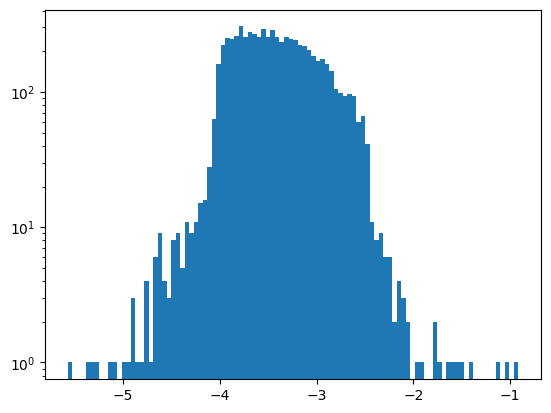

In [31]:
#kwargs = dict(range = [0, 2.5], histtype = 'stepfilled', alpha = 0.3, bins = 251)
plt.hist(rapiditys, bins = 100)
plt.yscale('log')

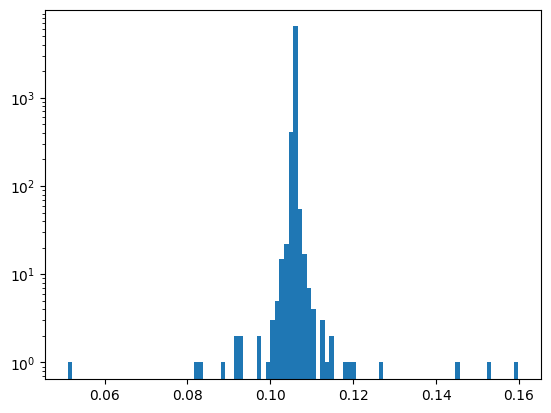

In [32]:
#kwargs = dict(range = [0, 2.5], histtype = 'stepfilled', alpha = 0.3, bins = 26)
plt.hist(m0s, bins = 100)
plt.yscale('log')

In [33]:
m0s = np.array([], dtype = float)
pTs = np.array([], dtype = float)
rapiditys = np.array([], dtype = float)
nofTracks=0 # il est toujours utile de compter ...
nofEvents=0 # 
for event in _[_.nMuons==2]:
    nofEvents+=1
    tracks = event["Muon"].to_list()
    for t in tracks:
        nofTracks+=1
        m0s = np.append(m0s, m0(t["E"], t["Px"], t["Py"], t["Pz"]))
        pTs = np.append(pTs, pT(t["Px"], t["Py"]))
        rapiditys = np.append(rapiditys, rapidity(t["E"], t["Pz"]))

In [34]:
# ... et de vérifier que le compte est bon !
print(nofEvents,len(m0s),nofTracks)

813 1626 1626


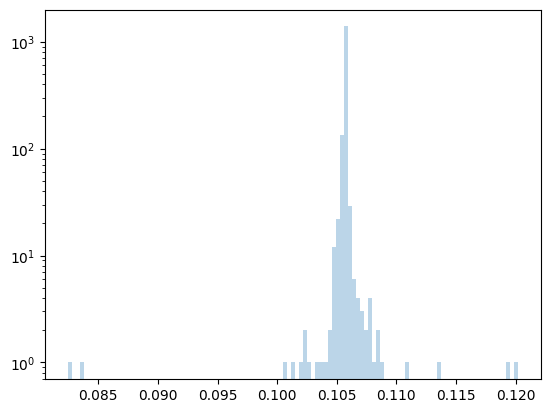

In [35]:
kwargs = dict( histtype = 'stepfilled', alpha = 0.3, bins = 111)
plt.hist(m0s, **kwargs)
plt.yscale('log')

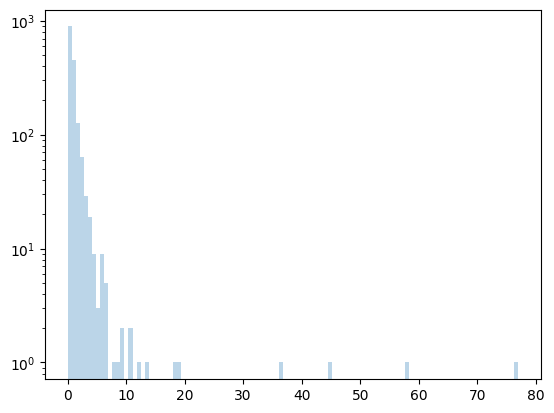

In [36]:
kwargs = dict(histtype = 'stepfilled', alpha = 0.3, bins = 111)
plt.hist(pTs, **kwargs)
plt.yscale('log')

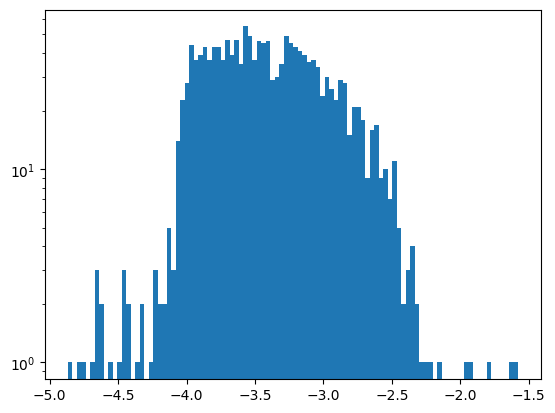

In [37]:
kwargs = dict(histtype = 'stepfilled', alpha = 0.3, bins = 111)
plt.hist(rapiditys, bins = 100)
plt.yscale('log')

In [38]:
opposite_sign = np.array([], dtype = float)
like_sign = np.array([], dtype = float)
nofTracks=0 # il est toujours utile de compter ...
nofEvents=0 # 
for event in _[_.nMuons==2]:
    nofEvents+=1
    tracks = event["Muon"].to_list()
    T = np.array([], dtype = int)
    for t in tracks:
        nofTracks+=1
        T = np.append(T, t["Charge"])
    if (T[0] == -1 and T[1] == 1) or (T[0] == 1 and T[1] == -1):
        #opposite_sign = np.append(opposite_sign, nofEvents)
        opposite_sign = np.append(opposite_sign, np.array(tracks))
    if (T[0] == 1 and T[1] == 1) or (T[0] == -1 and T[1] == -1):
        #like_sign = np.append(like_sign, nofEvents)
        like_sign = np.append(like_sign, np.array(tracks))

In [39]:
m0s_OS = np.array([], dtype = float)

compteur = -1
for t in opposite_sign:
    compteur += 1
    #input("1")
    
    if compteur == 0:
        Px = t["Px"]
        Py = t["Py"]
        Pz = t["Pz"]
        E = t["E"]
        #input("2")
        
    if compteur == 1:
        compteur = -1
       # input("3")
        Px += t["Px"]
        Py += t["Py"]
        Pz += t["Pz"]
        E += t["E"]
        
        m0s_OS = np.append(m0s, m0(E, Px, Py, Pz))

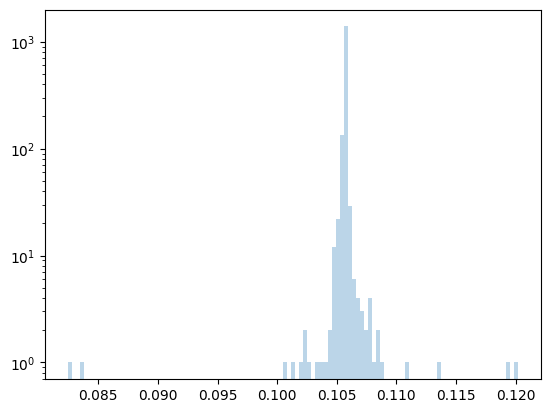

In [40]:
kwargs = dict(histtype = 'stepfilled', alpha = 0.3, bins = 111)
plt.hist(m0s, **kwargs)
plt.yscale('log')

In [41]:
m0s_LS = np.array([], dtype = float)

compteur = -1
for t in like_sign:
    compteur += 1
    #input("1")
    
    if compteur == 0:
        Px = t["Px"]
        Py = t["Py"]
        Pz = t["Pz"]
        E = t["E"]
        #input("2")
        
    if compteur == 1:
        compteur = -1
       # input("3")
        Px += t["Px"]
        Py += t["Py"]
        Pz += t["Pz"]
        E += t["E"]
        
        m0s_LS = np.append(m0s, m0(E, Px, Py, Pz))

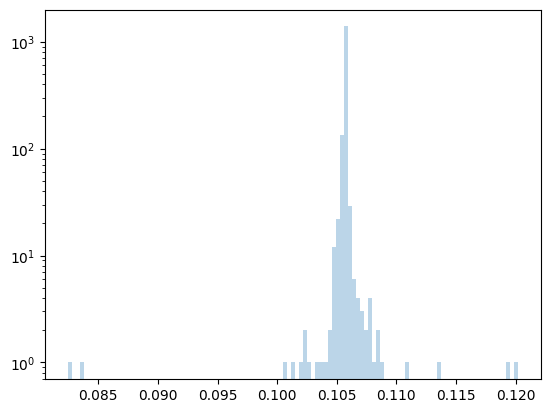

In [42]:
kwargs = dict(histtype = 'stepfilled', alpha = 0.3, bins = 111)
plt.hist(m0s, **kwargs)
plt.yscale('log')